<a href="https://colab.research.google.com/github/RVasconcelosMiguel/ComputerVision/blob/main/C%C3%B3pia_de_CV_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tqdm

In [2]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm  # Importar tqdm

import os
import pandas as pd
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
from torch.optim import Adam, SGD, NAdam
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler


import torchvision
from torchvision import models, transforms
from torchvision.io import read_image

from torchsummary import summary

import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm  # Importar tqdm

import os
import pandas as pd
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
from torch.optim import Adam, SGD, NAdam
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler


import torchvision
from torchvision import models, transforms
from torchvision.io import read_image

from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from PIL import Image
import zipfile


from PIL import Image
import zipfile

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")

The model will be running on cuda:0 device


In [4]:
# Clear existing files or directories from previous runs
!rm -f -r "/content/images"
!rm -f "/content/module_metadata.json"

# Define paths for download and extraction
repo_path = "/content/InfraredSolarModules/"
zip_path = "/content/2020-02-14_InfraredSolarModules.zip"
extract_path = "/content"

# Clone the repository and extract the zip file
!git clone https://github.com/RaptorMaps/InfraredSolarModules.git $repo_path
!mv "$repo_path/2020-02-14_InfraredSolarModules.zip" $extract_path
!unzip -uq $zip_path -d $extract_path

# Move images folder to the root directory
image_folder_path = "/content/InfraredSolarModules/images"
!mv $image_folder_path $extract_path

# Move module_metadata.json to the root directory
metadata_file_path = "/content/InfraredSolarModules/module_metadata.json"
!mv $metadata_file_path $extract_path

# Verify the final structure
!ls /content


Cloning into '/content/InfraredSolarModules'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 24 (delta 10), reused 12 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (24/24), 5.49 MiB | 4.67 MiB/s, done.
Resolving deltas: 100% (10/10), done.
2020-02-14_InfraredSolarModules.zip  InfraredSolarModules  module_metadata.json
images				     __MACOSX		   sample_data


In [42]:
# Path to metadata JSON file
metadata_path = '/content/module_metadata.json'

# Load metadata
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

# Convert metadata to DataFrame
df = pd.DataFrame.from_dict(metadata, orient='index')

# Binary Classification DataFrame
df_binary = df.copy()
df_binary['anomaly_class'] = df_binary['anomaly_class'].apply(
    lambda x: 1 if x.lower() != 'no-anomaly' else 0
)

# Display DataFrame details
print("*************** Binary Classification DataFrame ***************")
print(df_binary.head())
print("Total rows:", df_binary.shape[0])

train_ratio = 0.9
train_data, test_data = train_test_split(df_binary, test_size=(1-train_ratio), train_size=train_ratio, random_state=2, stratify=df_binary['anomaly_class'])

train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)


*************** Binary Classification DataFrame ***************
         image_filepath  anomaly_class
13357  images/13357.jpg              0
13356  images/13356.jpg              0
19719  images/19719.jpg              0
11542  images/11542.jpg              0
11543  images/11543.jpg              0
Total rows: 20000


In [43]:
"""
train_data, test_data=train_test_split(df_binary, test_size=0.15,train_size=0.85, random_state=2, stratify=df_binary["anomaly_class"])
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
"""



'\ntrain_data, test_data=train_test_split(df_binary, test_size=0.15,train_size=0.85, random_state=2, stratify=df_binary["anomaly_class"])\ntrain_data.reset_index(drop=True, inplace=True)\ntest_data.reset_index(drop=True, inplace=True)\n'

ESTÁ IGUAL AO DO VITOR TEMOS QUE MUDAR DAQUI PARA BAIXO

In [44]:
class MyImageDataset(data.Dataset):
    def __init__(self, metadata, transform=None, img_mode="L"):

        self.img_labels = metadata["anomaly_class"].values
        self.img_paths = metadata["image_filepath"].values
        self.transform = transform
        self.img_mode = img_mode

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):

        try:
            img_path = self.img_paths[idx]

            # Ensure the image file exists
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image file not found: {img_path}")

            # Open and convert the image
            image = Image.open(img_path).convert(self.img_mode)
            label = self.img_labels[idx]

            # Apply transformations if specified
            if self.transform:
                image = self.transform(image)

            return image, torch.tensor(label, dtype=torch.long)

        except Exception as e:
            raise RuntimeError(f"Error loading sample at index {idx}: {e}")

"""
class MyImageDataset(data.Dataset):
    def __init__(self, metadata, transform=None):
        self.img_labels = metadata["anomaly_class"].values
        self.img_paths = metadata["image_filepath"].values
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):#posteriormente o dataloader vai passar por todos os idx
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert("L") # Abrir a imagem como RGB
        label = self.img_labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)
"""


'\nclass MyImageDataset(data.Dataset):\n    def __init__(self, metadata, transform=None):\n        self.img_labels = metadata["anomaly_class"].values\n        self.img_paths = metadata["image_filepath"].values\n        self.transform = transform\n\n    def __len__(self):\n        return len(self.img_labels)\n\n    def __getitem__(self, idx):#posteriormente o dataloader vai passar por todos os idx\n        img_path = self.img_paths[idx]\n        image = Image.open(img_path).convert("L") # Abrir a imagem como RGB\n        label = self.img_labels[idx]\n\n        if self.transform:\n            image = self.transform(image)\n\n        return image, torch.tensor(label, dtype=torch.long)\n'

In [75]:
# Transformações
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flips the image horizontally
    transforms.RandomRotation(10),  # Randomly rotates the image by up to 10 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Testing transform without augmentation
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
# Datasets
train_dataset = MyImageDataset(metadata=train_data, transform=train_transform)
test_dataset = MyImageDataset(metadata=test_data, transform=test_transform)

# DataLoaders
batch_size = 16
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



torch.Size([1, 40, 24])


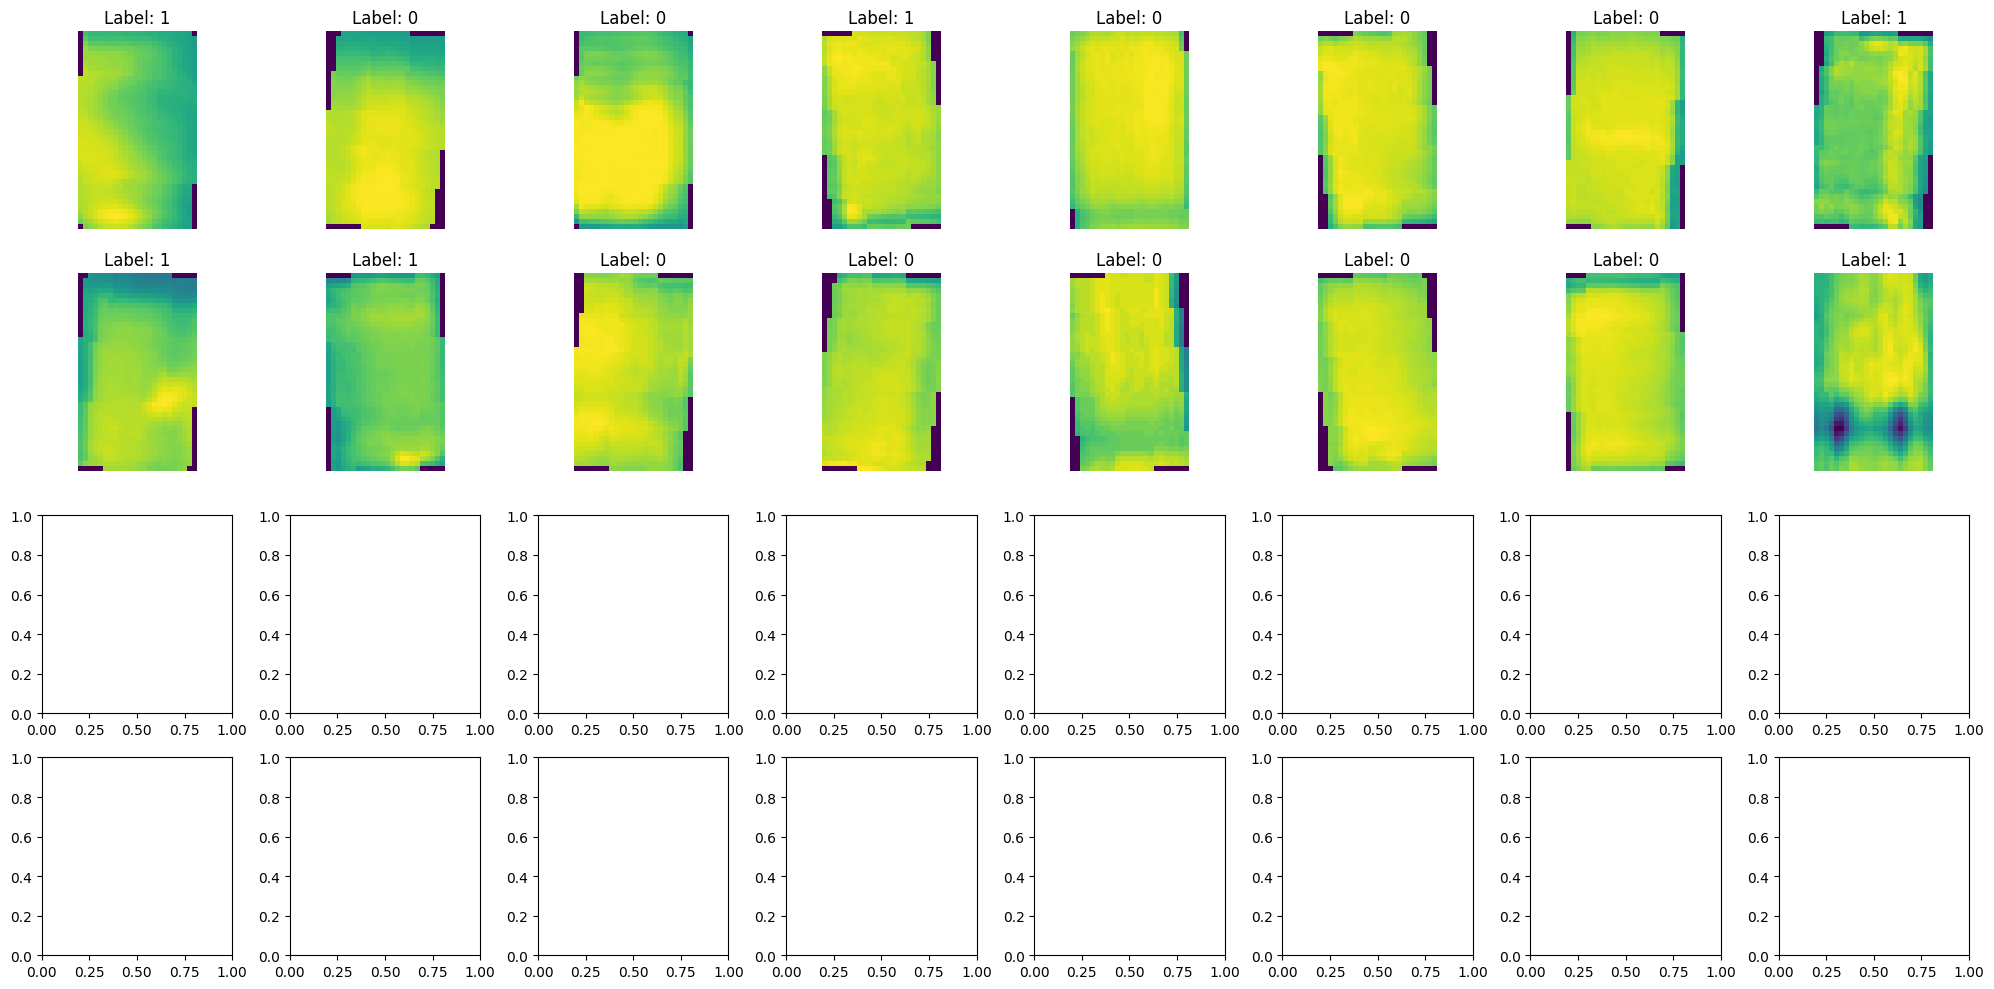

In [76]:
# Obtém um batch de imagens, seus rótulos e os caminhos
images, labels = next(iter(train_loader))  # Pega o primeiro batch

# Desfazendo a normalização para as imagens
images = images * 0.5 + 0.5  # Inverte a normalização, para voltar ao intervalo [0, 1]

# Cria uma figura com múltiplos subplots
fig, axes = plt.subplots(4, 8, figsize=(20, 10))  # 4 linhas e 8 colunas
axes = axes.flatten()  # Para facilitar o acesso aos eixos (axes)

# Loop para exibir as 32 primeiras imagens do batch
for i in range(len(images)):
    image = images[i]  # Pega a i-ésima imagem do batch
    image_pil = transforms.ToPILImage()(image)  # Converte o tensor para uma imagem PIL

    # Exibe a imagem
    axes[i].imshow(image_pil)
    axes[i].set_title(f"Label: {labels[i].item()}")  # Exibe o rótulo e o caminho do arquivo
    axes[i].axis('off')  # Remove os eixos para uma exibição mais limpa

print(images[0].shape)
plt.tight_layout()  # Ajusta o layout para que as imagens não se sobreponham
plt.show()







In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional and pooling layers with kernel size 5x5 for the first two layers, 3x3 for the third layer
        self.conv1 = nn.Conv2d(1, 128, 3)  # Kernel size 5x5
        self.bn1 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(128, 256, 3)  # Kernel size 5x5
        self.bn2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2, 2)  # Max pool layer (2x2)

        self.conv3 = nn.Conv2d(256, 512, 3)  # Kernel size 3x3 (adjusted for valid output size)
        self.bn3 = nn.BatchNorm2d(512)

        self.dropout_conv = nn.Dropout2d(0.2)

        # Calculating the correct input size for the fully connected layer
        # Initial    : (40, 24)
        # After conv1: (38, 22)
        # After pool1: (19, 11)
        # After conv2: (17, 9)
        # After pool2: (8, 4)
        # After conv3: (6, 2)

        self.fc1 = nn.Linear(512 * 6 * 2, 1024)  # Increased to 2048 neurons
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(1024, 512)         # Increased to 1024 neurons
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(512, 2)          # Increased to 512 neurons

    def forward(self, x):
        # First convolutional layer, ReLU, and pooling
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout_conv(x)  # Dropout2d after pooling
        x = F.relu(self.bn3(self.conv3(x)))

        # Flatten the output for the fully connected layer
        x = torch.flatten(x, 1)  # Flatten to [batch_size, 256*5*1]

        # Fully connected layers with ReLU and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)

        return x

model = Network()
# Define the loss function
loss_fn = nn.CrossEntropyLoss().to(device)

# Define the optimizer
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0025, momentum=0.9, weight_decay=1e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

In [78]:
from torch.autograd import Variable

# Function to save the model
def saveModel(model:nn.Module, path):
    torch.save(model.state_dict(), path)

# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          device: torch.device,
          num_epochs,
          path_model,
          verbatim):
    model.train()
    model.to(device)
    best_accuracy = 0.0
    best_loss = 0.0
    best_epoch = 0
    for epoch in tqdm(range(num_epochs), desc="Epochs", unit="epoch"):  # Adicionando a barra de progresso para os epochs

        train_acc = 0.0
        train_loss = 0.0
        for ibatch, (images, labels) in enumerate(dataloader):  # Adicionando a barra de progresso para os batches

            # get the inputs
            images = images.to(device)
            labels = labels.to(device)

            # 1. Forward pass
            y_pred = model(images)
            y_pred = y_pred.squeeze(dim=1)

            # 2. Calculate  and accumulate loss
            loss = loss_fn(y_pred, labels)
            train_loss += loss.item()

            # 3. Optimizer zero grad
            optimizer.zero_grad()

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            optimizer.step()

            # Calculate and accumulate accuracy metric across all batches
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            train_acc += (y_pred_class == labels).sum().item()/len(y_pred)

        # Adjust metrics to get average loss and accuracy per batch
        train_loss = train_loss / len(dataloader)
        train_acc = train_acc / len(dataloader)

        # we want to save the model if the accuracy is the best


        if train_acc > best_accuracy:
            path = str(path_model)
            saveModel(model, path = path)
            best_loss = train_loss
            best_accuracy = train_acc
            best_epoch = epoch
            if verbatim:
              print('Best Epoch #', epoch,' Loss=', best_loss, " Accu=", best_accuracy )

    return best_loss, best_accuracy, best_epoch

In [79]:
# Function to test the model with the test dataset and print the accuracy for the test images
def test(model: torch.nn.Module,
         dataloader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         device: torch.device,
         verbatim = True):

    # Put model in eval mode
    model.eval()
    model.to(device)
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    pred_labels = []
    with torch.no_grad():
        for data in dataloader:

            # get the inputs
            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # 1. run the model on the test set to predict labels
            y_pred = model(images)

            # 2. Calculate and accumulate loss
            loss = loss_fn(y_pred, labels)
            test_loss += loss.item()

            # 3. Calculate and accumulate accuracy
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc += (y_pred_class == labels).sum().item()/len(y_pred)
            pred_labels = y_pred_class.tolist()

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    if verbatim:
      print("Loss =", test_loss, "  Accuracy=", test_acc)
    return pred_labels, test_loss, test_acc


In [80]:
if __name__ == "__main__":

    model = model.to(device)

    # Build our model
    best_loss, best_accuracy, best_epoch = train(model=model,
                                                    dataloader=train_loader,
                                                    loss_fn=loss_fn,
                                                    optimizer=optimizer,
                                                    device=device,
                                                    num_epochs = 50,
                                                    path_model = str("./myModel_best_A.pth"),
                                                    verbatim = True)

Epochs:   2%|▏         | 1/50 [00:22<18:03, 22.10s/epoch]

Best Epoch # 0  Loss= 0.5186579954889086  Accu= 0.736


Epochs:   4%|▍         | 2/50 [00:44<17:52, 22.33s/epoch]

Best Epoch # 1  Loss= 0.4131250871154997  Accu= 0.8132222222222222


Epochs:   6%|▌         | 3/50 [01:07<17:49, 22.75s/epoch]

Best Epoch # 2  Loss= 0.3739419975413216  Accu= 0.8351666666666666


Epochs:   8%|▊         | 4/50 [01:29<17:12, 22.44s/epoch]

Best Epoch # 3  Loss= 0.3564911747177442  Accu= 0.8498888888888889


Epochs:  10%|█         | 5/50 [01:51<16:43, 22.30s/epoch]

Best Epoch # 4  Loss= 0.33561823580000133  Accu= 0.8585


Epochs:  12%|█▏        | 6/50 [02:13<16:10, 22.06s/epoch]

Best Epoch # 5  Loss= 0.3166448401759068  Accu= 0.8696111111111111


Epochs:  14%|█▍        | 7/50 [02:35<15:47, 22.04s/epoch]

Best Epoch # 6  Loss= 0.3087670410176118  Accu= 0.8701111111111111


Epochs:  16%|█▌        | 8/50 [02:57<15:20, 21.92s/epoch]

Best Epoch # 7  Loss= 0.2985011701616976  Accu= 0.8777222222222222


Epochs:  18%|█▊        | 9/50 [03:19<14:58, 21.92s/epoch]

Best Epoch # 8  Loss= 0.2918907367123498  Accu= 0.8830555555555556


Epochs:  20%|██        | 10/50 [03:40<14:33, 21.84s/epoch]

Best Epoch # 9  Loss= 0.27783823869956864  Accu= 0.888


Epochs:  22%|██▏       | 11/50 [04:02<14:14, 21.90s/epoch]

Best Epoch # 10  Loss= 0.271090343306462  Accu= 0.8927777777777778


Epochs:  26%|██▌       | 13/50 [04:47<13:42, 22.22s/epoch]

Best Epoch # 12  Loss= 0.25498335830536156  Accu= 0.8991666666666667


Epochs:  28%|██▊       | 14/50 [05:09<13:20, 22.24s/epoch]

Best Epoch # 13  Loss= 0.2503103992011812  Accu= 0.9002777777777777


Epochs:  30%|███       | 15/50 [05:31<12:56, 22.18s/epoch]

Best Epoch # 14  Loss= 0.24740949106713137  Accu= 0.9013333333333333


Epochs:  32%|███▏      | 16/50 [05:54<12:34, 22.20s/epoch]

Best Epoch # 15  Loss= 0.24113608767588934  Accu= 0.9056111111111111


Epochs:  34%|███▍      | 17/50 [06:15<12:10, 22.12s/epoch]

Best Epoch # 16  Loss= 0.23521824976884656  Accu= 0.9085


Epochs:  36%|███▌      | 18/50 [06:38<11:48, 22.14s/epoch]

Best Epoch # 17  Loss= 0.23012133542531066  Accu= 0.9112777777777777


Epochs:  40%|████      | 20/50 [07:21<10:59, 21.98s/epoch]

Best Epoch # 19  Loss= 0.22364354676091008  Accu= 0.914


Epochs:  42%|████▏     | 21/50 [07:43<10:34, 21.90s/epoch]

Best Epoch # 20  Loss= 0.2187160332881742  Accu= 0.9148333333333334


Epochs:  44%|████▍     | 22/50 [08:05<10:16, 22.01s/epoch]

Best Epoch # 21  Loss= 0.2160466284023391  Accu= 0.9156111111111112


Epochs:  46%|████▌     | 23/50 [08:27<09:51, 21.91s/epoch]

Best Epoch # 22  Loss= 0.21243862865865232  Accu= 0.9158888888888889


Epochs:  48%|████▊     | 24/50 [08:50<09:40, 22.33s/epoch]

Best Epoch # 23  Loss= 0.20666003382288747  Accu= 0.9199444444444445


Epochs:  50%|█████     | 25/50 [09:12<09:10, 22.04s/epoch]

Best Epoch # 24  Loss= 0.20104115095900166  Accu= 0.9217777777777778


Epochs:  52%|█████▏    | 26/50 [09:34<08:54, 22.26s/epoch]

Best Epoch # 25  Loss= 0.19916012749489811  Accu= 0.9225555555555556


Epochs:  54%|█████▍    | 27/50 [09:56<08:26, 22.02s/epoch]

Best Epoch # 26  Loss= 0.195766182165179  Accu= 0.9247222222222222


Epochs:  60%|██████    | 30/50 [11:02<07:21, 22.08s/epoch]

Best Epoch # 29  Loss= 0.18475400292128324  Accu= 0.929


Epochs:  64%|██████▍   | 32/50 [11:46<06:36, 22.03s/epoch]

Best Epoch # 31  Loss= 0.18650720933493642  Accu= 0.9306111111111111


Epochs:  66%|██████▌   | 33/50 [12:07<06:11, 21.85s/epoch]

Best Epoch # 32  Loss= 0.1765623193151421  Accu= 0.9343333333333333


Epochs:  72%|███████▏  | 36/50 [13:15<05:10, 22.20s/epoch]

Best Epoch # 35  Loss= 0.1720309628546238  Accu= 0.9356666666666666


Epochs:  74%|███████▍  | 37/50 [13:36<04:45, 21.96s/epoch]

Best Epoch # 36  Loss= 0.1662071058050626  Accu= 0.9387777777777778


Epochs:  82%|████████▏ | 41/50 [15:03<03:15, 21.77s/epoch]

Best Epoch # 40  Loss= 0.16083881117569077  Accu= 0.9390555555555555


Epochs:  84%|████████▍ | 42/50 [15:25<02:54, 21.82s/epoch]

Best Epoch # 41  Loss= 0.15586399632278417  Accu= 0.94


Epochs:  88%|████████▊ | 44/50 [16:09<02:11, 21.86s/epoch]

Best Epoch # 43  Loss= 0.15819258819313514  Accu= 0.9404444444444444


Epochs:  90%|█████████ | 45/50 [16:30<01:48, 21.79s/epoch]

Best Epoch # 44  Loss= 0.14972150162152117  Accu= 0.9428888888888889


Epochs:  94%|█████████▍| 47/50 [17:16<01:06, 22.19s/epoch]

Best Epoch # 46  Loss= 0.14735196673497558  Accu= 0.9444444444444444


Epochs:  96%|█████████▌| 48/50 [17:37<00:44, 22.05s/epoch]

Best Epoch # 47  Loss= 0.1470376676465902  Accu= 0.9452222222222222


Epochs: 100%|██████████| 50/50 [18:21<00:00, 22.04s/epoch]


In [81]:
y_pred, test_loss, test_acc  = test(model=model,
                                    dataloader=test_loader,
                                    loss_fn=loss_fn,
                                    device=device,
                                    verbatim = True)

Loss = 0.20655566700175404   Accuracy= 0.942
